# Arbre de décision

Par Serigne DIOP

### Choix du modéle

L'arbre de décision est un bon choix pour la classification du cancer cervical en raison de sa capacité à gérer des données complexes et à capturer des interactions entre les variables. Son interprétabilité permet aux médecins de visualiser facilement les critères influençant le diagnostic, tout en offrant de bonnes performances sur des jeux de données médicaux limités.

### Importation des librairies

In [27]:
import numpy as np
import pandas as pd
import os
import sys
import pickle  
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split,KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict, cross_val_score

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
#from mlxtend.plotting import plot_decision_regions

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc

### Importation du fichier des variables

In [19]:
with open("variables.pkl", "rb") as f:
    df, X_train, X_test, y_train, y_test, X_train_smote, y_train_smote = pickle.load(f)

print("Les données ont été chargées avec succès.")

Les données ont été chargées avec succès.


### Instantion, entrainement et évaluation


Accuracy sur le test set: 0.95
AUC sur le test set: 0.97


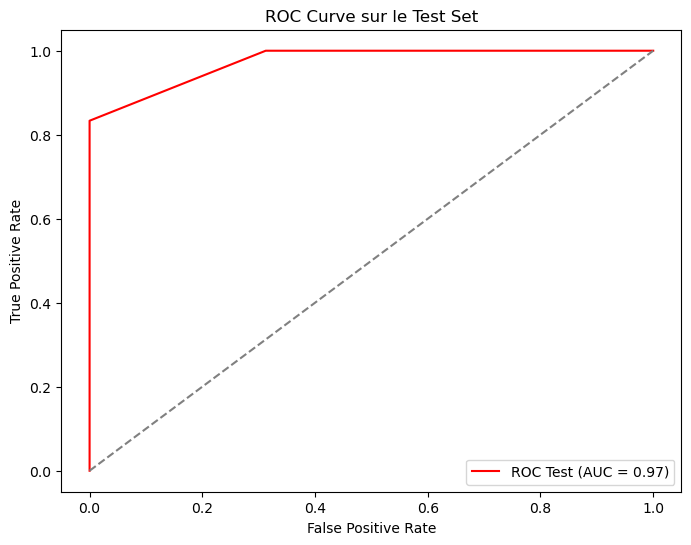

In [20]:
# Initialisation des paramètres
mean_fpr = np.linspace(0, 1, 100)  # Axe X pour la courbe ROC
tprs = []
accuracies = []

# Définir le modèle
model_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=5, 
                                    class_weight='balanced', random_state=42)

# Définir la validation croisée stratifiée à 5 plis
cv = KFold(n_splits=10, shuffle=True, random_state=18)

# Obtenir les prédictions probables avec cross-validation
y_prob = cross_val_predict(model_tree, X_train_smote, y_train_smote, cv=cv, method="predict_proba")[:, 1]

# Obtenir la précision avec cross-validation
accuracies = cross_val_score(model_tree, X_train_smote, y_train_smote, cv=cv, scoring="accuracy")
# Entraîner le modèle sur tout le train set
model_tree.fit(X_train_smote, y_train_smote)

# Prédire sur le test set
y_prob_test = model_tree.predict_proba(X_test)[:, 1]  
y_pred_test = model_tree.predict(X_test)

# Évaluer sur le test set
test_accuracy = accuracy_score(y_test, y_pred_test)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)

print(f"\nAccuracy sur le test set: {test_accuracy:.2f}")
print(f"AUC sur le test set: {roc_auc_test:.2f}")

# Tracer la courbe ROC pour le test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='red', label=f'ROC Test (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve sur le Test Set')
plt.legend()
plt.show()


### Interprétation

### Courbe ROC aprés Cross-Validation


Précision moyenne du modèle : 0.82


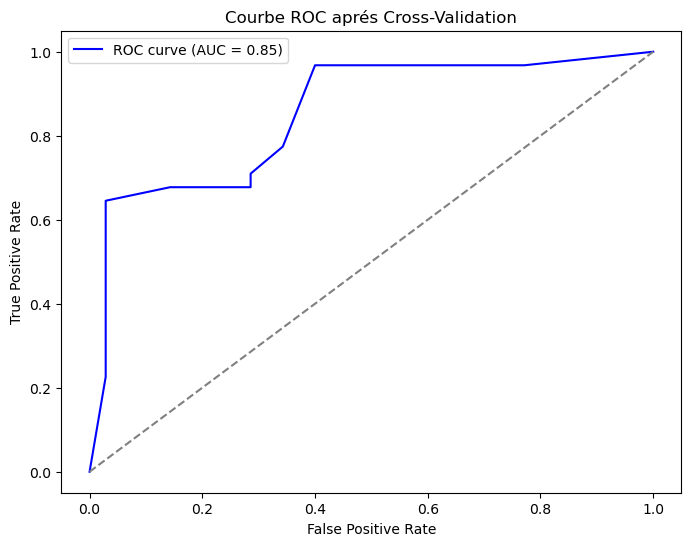

In [30]:
# Courbe ROC moyenne
fpr, tpr, _ = roc_curve(y_train_smote, y_prob)
roc_auc = auc(fpr, tpr)

# Affichage des résultats
print(f"\nPrécision moyenne du modèle : {np.mean(accuracies):.2f}")

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonale aléatoire
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC aprés Cross-Validation')
plt.legend()
plt.show()

### Analyse et interprétation

### Optimisation 

Meilleurs hyperparamètres :  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}
Meilleure précision obtenue :  0.8714285714285713

Précision moyenne du modèle après optimisation : 0.82


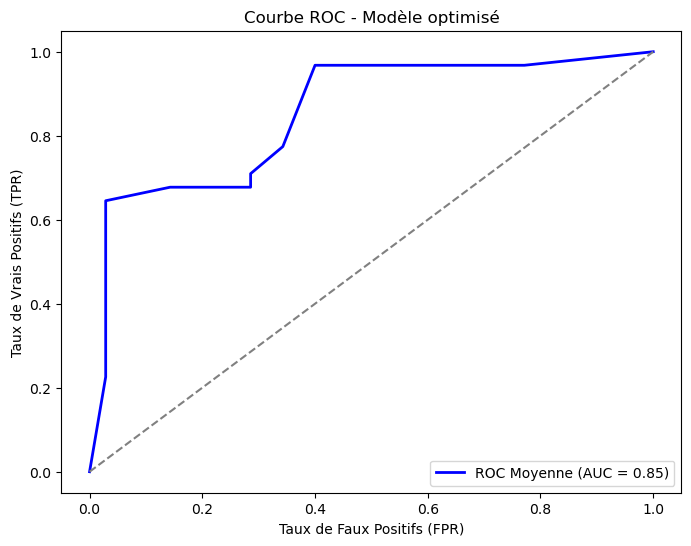

In [31]:
# Définition de la grille d'hyperparamètres pour GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

# Initialisation du modèle de l'arbre de décision
model_tree_opt = DecisionTreeClassifier(random_state=42)

# Initialisation de la validation croisée à 5 folds
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Création de GridSearchCV avec 5-fold cross-validation
grid_search = GridSearchCV(estimator=model_tree_opt, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy')

# Entraînement avec la validation croisée
grid_search.fit(X_train_smote, y_train_smote)

# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Affichage de la meilleure précision obtenue
print("Meilleure précision obtenue : ", grid_search.best_score_)

# Initialisation des variables pour stocker les résultats des 5 folds
accuracies = []
mean_fpr = np.linspace(0, 1, 100)
tprs = []
mean_auc = 0


# Initialisation de la validation croisée
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Récupérer le meilleur modèle trouvé par GridSearchCV
best_model_opt = grid_search.best_estimator_

# Prédictions des probabilités pour chaque fold via cross-validation
y_prob = cross_val_predict(best_model_opt, X_train_smote, y_train_smote, cv=cv, method="predict_proba")[:, 1]

# Précision moyenne obtenue par validation croisée
accuracies = cross_val_score(best_model_opt, X_train_smote, y_train_smote, cv=cv, scoring="accuracy")
mean_accuracy = np.mean(accuracies)

# Courbe ROC globale
fpr, tpr, _ = roc_curve(y_train_smote, y_prob)
roc_auc = auc(fpr, tpr)

# Affichage des résultats
print(f"\nPrécision moyenne du modèle après optimisation : {mean_accuracy:.2f}")

# Tracer la courbe ROC moyenne
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Moyenne (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonale aléatoire
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC - Modèle optimisé')
plt.legend(loc="lower right")
plt.show()

### Interpretation

### Critiques

### Exporter les variables

In [37]:
roc_data_tree = {
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc
}

# Sauvegarder les données dans un fichier pickle
with open('roc_data_tree.pkl', 'wb') as file:
    pickle.dump(roc_data_tree, file)

print("Les données ROC et AUC ont été enregistrées avec succès dans 'roc_data_tree.pkl'.")

Les données ROC et AUC ont été enregistrées avec succès dans 'roc_data_tree.pkl'.
